## Loading All the libraries

In [1]:
import tensorflow as tf
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, Add
from keras.layers import Input, Flatten, GlobalAveragePooling2D
from keras.models import Model
import math
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds

# Import the necessary callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, LearningRateScheduler

## Settinhg up the parameters & hyper-parameters

In [2]:
# setting the hyperparameters
image_size = 32
image_channels = 3
batch_size = 500
temperature = 0.1
epochs = 100
initial_learning_rate = 0.001
LARGE_NUM = 1e9

In [3]:
# Stronger augmentations for contrastive, weaker ones for supervised training
contrastive_augmentation = {"min_area": 0.25, "brightness": 0.6, "jitter": 0.2}

## Dataset Preparation and Loadeing

In [4]:
def prepare_dataset():

    train_dataset = (
        tfds.load("cifar10", split='train', as_supervised=True)
        .batch(batch_size)
    )
    return train_dataset

In [5]:
# Load Cifar10 dataset
train_dataset= prepare_dataset()

## Creating Augmentation pipeline

In [6]:
class RandomResizedCrop(layers.Layer):
    def __init__(self, ratio):
        super().__init__()
        self.scale = (0.2, 1.0)
        self.log_ratio = (tf.math.log(ratio[0]), tf.math.log(ratio[1]))

    def call(self, images):
        batch_size = tf.shape(images)[0]
        height = tf.shape(images)[1]
        width = tf.shape(images)[2]

        random_scales = tf.random.uniform((batch_size,), self.scale[0], self.scale[1])
        random_ratios = tf.exp(
            tf.random.uniform((batch_size,), self.log_ratio[0], self.log_ratio[1])
        )

        new_heights = tf.clip_by_value(tf.sqrt(random_scales / random_ratios), 0, 1)
        new_widths = tf.clip_by_value(tf.sqrt(random_scales * random_ratios), 0, 1)
        height_offsets = tf.random.uniform((batch_size,), 0, 1 - new_heights)
        width_offsets = tf.random.uniform((batch_size,), 0, 1 - new_widths)

        bounding_boxes = tf.stack(
            [
                height_offsets,
                width_offsets,
                height_offsets + new_heights,
                width_offsets + new_widths,
            ],
            axis=1,
        )
        images = tf.image.crop_and_resize(
            images, bounding_boxes, tf.range(batch_size), (height, width)
        )
        return images

In [7]:
class GaussianBlurLayer(tf.keras.layers.Layer):
    def __init__(self, kernel_size, std_dev):
        super(GaussianBlurLayer, self).__init__()
        self.kernel_size = kernel_size
        self.std_dev = std_dev

    def build(self, input_shape):
        # Create Gaussian kernel
        kernel = self._create_gaussian_kernel()
        kernel = tf.cast(kernel, tf.float32) 
        # Preparesthe kernel for 3 channels
        self.kernel = tf.reshape(kernel, shape=[self.kernel_size, self.kernel_size, 1, 1]) * tf.ones([1,1,3,1])

    def call(self, inputs):
        # Apply convolution to blur image
        blurred = tf.nn.depthwise_conv2d(inputs, self.kernel, strides=[1, 1, 1, 1], padding='SAME')
        return blurred

    def _create_gaussian_kernel(self):
        # Create 1D Gaussian kernel
        kernel_1D = tf.range(-self.kernel_size // 2 + 1, self.kernel_size // 2 + 1)
        kernel_1D = tf.math.square(kernel_1D)
        kernel_2D = tf.einsum('i,j->ij', kernel_1D, kernel_1D)
        kernel_2D = tf.exp(-kernel_2D / (2 * self.std_dev * self.std_dev))
        kernel_2D /= tf.reduce_sum(kernel_2D)
        return kernel_2D

In [8]:
class RandomColorJitterLayer(tf.keras.layers.Layer):
    def __init__(self, brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02, **kwargs):
        super().__init__(**kwargs)
        
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue

    def call(self, images, training=True):
        if training:
            # Apply color transformations with a 0.8 probability
            if tf.random.uniform([]) < 0.8:
                images = tf.image.random_brightness(images, max_delta=self.brightness)
                images = tf.image.random_contrast(images, lower=1-self.contrast, upper=1+self.contrast)
                images = tf.image.random_saturation(images, lower=1-self.saturation, upper=1+self.saturation)
                images = tf.image.random_hue(images, max_delta=self.hue)

        return images

In [9]:
# Image augmentation module
def get_augmenter(min_area, brightness, jitter):
    zoom_factor = 1.0 - math.sqrt(min_area)
    return keras.Sequential(
        [
            keras.Input(shape=(image_size, image_size, image_channels)),
            
            RandomResizedCrop(ratio=(3 / 4, 4 / 3)),
            
            layers.RandomFlip("horizontal"),
            RandomColorJitterLayer(),
            #RandomGrayscale(),
            GaussianBlurLayer(kernel_size = 3, std_dev = 1),
            layers.Rescaling(1 / 255),
        ]
    )

## Visualizing Augmentation on some of the dataset

In [10]:
def visualize_augmentations(num_images):
    # Sample a batch from a dataset
    images = next(iter(train_dataset))[0][:num_images]
    # Apply augmentations
    augmented_images = zip(
        images,
        get_augmenter(**contrastive_augmentation)(images),
        get_augmenter(**contrastive_augmentation)(images),
    )
    row_titles = [
        "Original:",
        "Strongly augmented:",
        "Strongly augmented:",
    ]
    plt.figure(figsize=(num_images * 2.2, 3 * 2.2), dpi=100)
    for column, image_row in enumerate(augmented_images):
        for row, image in enumerate(image_row):
            plt.subplot(3, num_images, row * num_images + column + 1)
            plt.imshow(image)
            if column == 0:
                plt.title(row_titles[row], loc="left")
            plt.axis("off")
    plt.tight_layout()

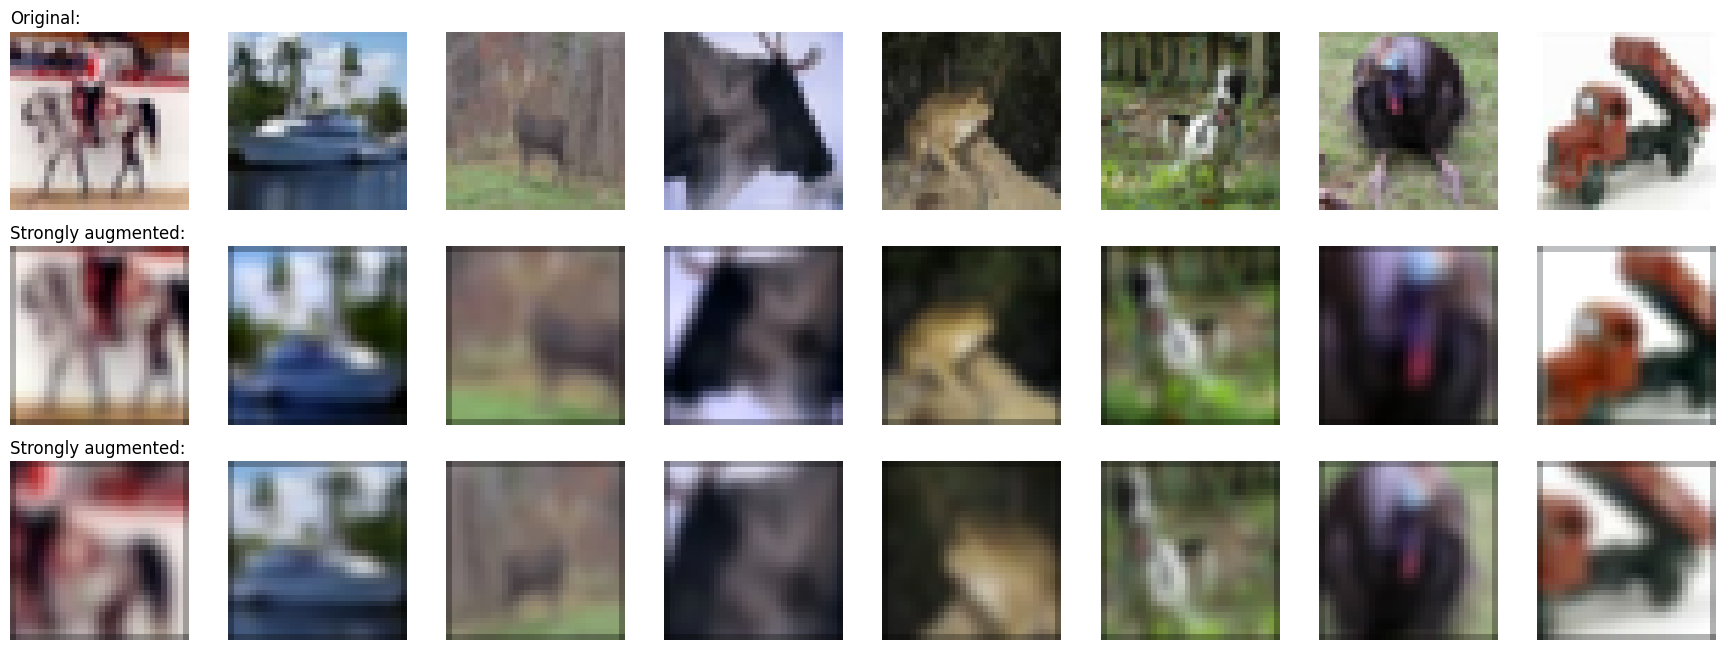

In [11]:
#Executing the visualizer
visualize_augmentations(num_images=8)

## Creating the encoder

In [12]:
# Step 3: Define the ResNet-18 model
from keras import layers
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import AveragePooling2D
from keras.layers import Flatten
from keras.layers import MaxPool2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.models import Model
from keras.regularizers import l2



def conv2d_bn(x, filters, kernel_size, strides=(1, 1)):
    layer = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same',
                   )(x)
    layer = BatchNormalization()(layer)
    return layer

def conv2d_bn_relu(x, filters, kernel_size, strides=(1, 1)):
    layer = conv2d_bn(x, filters, kernel_size, strides)
    layer = Activation('relu')(layer)
    return layer

def ResidualBlock(x, filters, kernel_size, downsample=True):
    if downsample:
        # residual_x = conv2d_bn_relu(x, filters, kernel_size=1, strides=2)
        residual_x = conv2d_bn(x, filters, kernel_size=1, strides=2)
        stride = 2
    else:
        residual_x = x
        stride = 1
    residual = conv2d_bn_relu(x,
                              filters=filters,
                              kernel_size=kernel_size,
                              strides=stride,
                              )
    residual = conv2d_bn(residual,
                         filters=filters,
                         kernel_size=kernel_size,
                         strides=1,
                         )
    out = layers.add([residual_x, residual])
    out = Activation('relu')(out)
    return out

def ResNet18(input_shape=(32, 32, 3)):
    input = Input(shape=input_shape)
    x = input
    #x = conv2d_bn_relu(x, filters=64, kernel_size=(7, 7), strides=(2, 2))
    #x = MaxPool2D(pool_size=(3, 3), strides=(2, 2),  padding='same')(x)
    x = conv2d_bn_relu(x, filters=64, kernel_size=(3, 3), strides=(1, 1))

    # # conv 2
    x = ResidualBlock(x, filters=64, kernel_size=(3, 3), downsample=False)
    x = ResidualBlock(x, filters=64, kernel_size=(3, 3),  downsample=False)
    # # conv 3
    x = ResidualBlock(x, filters=128, kernel_size=(3, 3),  downsample=True)
    x = ResidualBlock(x, filters=128, kernel_size=(3, 3),  downsample=False)
    # # conv 4
    x = ResidualBlock(x, filters=256, kernel_size=(3, 3),  downsample=True)
    x = ResidualBlock(x, filters=256, kernel_size=(3, 3),  downsample=False)
    # # conv 5
    x = ResidualBlock(x, filters=512, kernel_size=(3, 3),  downsample=True)
    x = ResidualBlock(x, filters=512, kernel_size=(3, 3),  downsample=False)
    x = AveragePooling2D(pool_size=(4, 4), padding='valid')(x)
    x = GlobalAveragePooling2D()(x)
    #x = Dense(classes, activation='softmax')(x)
    model = Model(input, x, name='ResNet18')
    return model

## Define the Contrastive learning model as Class object

The model contains three primary components :

- an encoder (ResNet-18, pretrained with 100 epochs on cifar10) for feature extraction, 
- a projection head that maps high-dimensional representations to low-dimensional ones (performs a dimensionality reduction), and 
- a linear probe that acts as a classifier for final category prediction.

The model consists of these main parts:

1. `__init__()` method: Initializes the model components such as augmenters for data augmentation, encoder for feature extraction, projection head (a non-linear multi-layer perceptron), and linear probe for classification.

2. `compile()` method: Compiles the model and sets up the optimizers, loss functions, and metrics used for training and evaluation.

3. `contrastive_loss_orig()` method: Computes the original contrastive loss (also known as the InfoNCE loss, or NT-Xent loss) using the cosine similarity of projections.

4. `contrastive_loss_ones()` method: Computes a modified contrastive loss , which essentially forces the positive pairs' similarity to be 1.

5. `train_step()` method: Defines the training step for the model, where it optimizes the contrastive loss using augmented images and optimizes the probe loss using preprocessed images with their labels.
6. `test_step()` method: Defines the test step for the custom model, where it calculates the probe loss and accuracy using the preprocessed images and labels.

### train_step

1. At the beginning of the function, two sets of augmented images are created from the input images using the `contrastive_augmenter`. Each set has different augmentations applied to the original images.

2. A `tf.GradientTape()` context is created to record gradients for optimizing the contrastive loss.

3. Within this context:
   - The features are extracted from both sets of augmented images using the `encoder`.
   - The extracted features are passed through the projection head to get the low-dimensional representations, denoted by `projections_1` and `projections_2`.
   - Depending on the current `global_step`, either the `original_loss_fn` (original contrastive loss) or the `modified_loss_fn` (custom contrastive loss) is used.
   
4. After exiting the `tf.GradientTape()` context, gradients are calculated for each trainable weight in the encoder and projection head. The `contrastive_optimizer` is then used to update the weights using the computed gradients.

5. The contrastive loss tracker is updated with the calculated contrastive loss.

6. Another set of preprocessed images is created using the `classification_augmenter`. These preprocessed images are used for an on-the-fly logistic regression for the probe task.

7. A new `tf.GradientTape()` context is created to record gradients for optimizing the probe loss.

8. Within this context:
   - Features are extracted from preprocessed images using the encoder in inference mode (to avoid regularization and batch normalization updates).
   - The extracted features are passed through the linear probe to get class logits.
   - The probe loss is calculated using the provided `labels` and the calculated class logits.
   
9. After exiting the `tf.GradientTape()` context, gradients are calculated for the linear probe's trainable weights. The `probe_optimizer` is then used to update the weights using the computed gradients.

10. The probe loss tracker and probe accuracy metrics are updated.

11. Finally, the `global_step` variable is incremented by 1.


In [13]:
# Define the contrastive model with model-subclassing
class ContrastiveModel(keras.Model):
    def __init__(self):
        super().__init__()

        self.temperature = temperature
        self.global_step = tf.Variable(0, dtype=tf.int64)  
        self.switch_loss_after_steps = tf.Variable(1000, dtype=tf.int64)
        self.contrastive_augmenter = get_augmenter(**contrastive_augmentation)
        self.encoder = ResNet18()
        # Non-linear MLP as projection head
        self.projection_head = keras.Sequential(
            [
                keras.Input(shape=(512,)),
                layers.Dense(128, activation="relu"),
                layers.Dense(128),
            ],
            name="projection_head",
        )
        

        self.encoder.summary()
        self.projection_head.summary()
    

        
        

    def compile(self, optimizer ,**kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = optimizer
        self.contrastive_loss_tracker = keras.metrics.Mean(name="c_loss")


    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker,
        ]
    

    def NT_Xent_Loss(self,z1,z2):

        batch_size = tf.shape(z1)[0]
        z=tf.concat([z1,z2],axis=0)

        z=tf.math.l2_normalize(z,axis=1)

        cosine_similarity=tf.matmul(z,z,transpose_b=True)
        cosine_similarity=cosine_similarity/self.temperature
        cosine_similarity=tf.math.exp(cosine_similarity)
        cosine_similarity=cosine_similarity-tf.linalg.diag(tf.linalg.diag_part(cosine_similarity))
        
        sim_11=tf.expand_dims(tf.linalg.diag_part(cosine_similarity,k=batch_size),axis=1)
        sim_22=tf.expand_dims(tf.linalg.diag_part(cosine_similarity,k=-batch_size),axis=1)
        pos_sim=tf.concat([sim_11,sim_22],axis=0)
       
        negatives=tf.reduce_sum(cosine_similarity,axis=1,keepdims=True)-pos_sim
        
        numerator=pos_sim
        denominator=pos_sim + negatives

        
        loss=-tf.math.log(numerator/denominator)

        return tf.reduce_mean(loss)
    


    def NT_Xent_Loss_negatives_only(self,z1,z2):

        batch_size = tf.shape(z1)[0]
        z=tf.concat([z1,z2],axis=0)

        z=tf.math.l2_normalize(z,axis=1)

        cosine_similarity=tf.matmul(z,z,transpose_b=True)
        cosine_similarity=cosine_similarity/self.temperature
        cosine_similarity=tf.math.exp(cosine_similarity)
        cosine_similarity=cosine_similarity-tf.linalg.diag(tf.linalg.diag_part(cosine_similarity))
        
        sim_11=tf.expand_dims(tf.linalg.diag_part(cosine_similarity,k=batch_size),axis=1)
        sim_22=tf.expand_dims(tf.linalg.diag_part(cosine_similarity,k=-batch_size),axis=1)
        pos_sim=tf.concat([sim_11,sim_22],axis=0)
       
        negatives=tf.reduce_sum(cosine_similarity,axis=1,keepdims=True)-pos_sim

       
        
        loss = tf.math.log(negatives)

        return tf.reduce_mean(loss)
  




    def train_step(self, data):
        images, labels = data

        def original_loss_fn():
            return self.NT_Xent_Loss(projections_1, projections_2)

        def modified_loss_fn():
            return self.NT_Xent_Loss_negatives_only(projections_1, projections_2)


        # Both labeled and unlabeled images are used, without labels
        # Each image is augmented twice, differently
        augmented_images_1 = self.contrastive_augmenter(images, training=True)
        augmented_images_2 = self.contrastive_augmenter(images, training=True)
        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1, training=True)
            features_2 = self.encoder(augmented_images_2, training=True)
            # The representations are passed through a projection mlp
            projections_1 = self.projection_head(features_1, training=True)
            projections_2 = self.projection_head(features_2, training=True)

            contrastive_loss = tf.cond(
                self.global_step < self.switch_loss_after_steps,
                true_fn = modified_loss_fn,
                false_fn = original_loss_fn,
                                       )

        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.contrastive_loss_tracker.update_state(contrastive_loss)

        self.global_step.assign_add(1)

        return {m.name: m.result() for m in self.metrics}

## defining the pretrained model and set the hyperparameters

In [14]:
pretraining_model = ContrastiveModel()

Model: "ResNet18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   1792        ['input_4[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 64)   0           ['batch_normalization[0][0

In [15]:
optimizer = keras.optimizers.Adam()

callbacks = [
    #EarlyStopping(monitor='c_loss', patience=10),
    TensorBoard(log_dir='logs/negative_only', histogram_freq=1)
]

In [16]:
pretraining_model.compile(optimizer)

## Traning the model

In [17]:
pretraining_model.fit(train_dataset, epochs=epochs, callbacks=callbacks)

Epoch 1/100
100/100 [==============================] - 61s 506ms/step - c_loss: 8.9746
Epoch 2/100
100/100 [==============================] - 51s 515ms/step - c_loss: 7.7546
Epoch 3/100
100/100 [==============================] - 50s 497ms/step - c_loss: 7.6096
Epoch 4/100
100/100 [==============================] - 50s 501ms/step - c_loss: 7.5430
Epoch 5/100
100/100 [==============================] - 52s 518ms/step - c_loss: 7.5097
Epoch 6/100
100/100 [==============================] - 52s 517ms/step - c_loss: 7.4781
Epoch 7/100
100/100 [==============================] - 52s 516ms/step - c_loss: 7.4633
Epoch 8/100
100/100 [==============================] - 52s 516ms/step - c_loss: 7.4511
Epoch 9/100
100/100 [==============================] - 52s 517ms/step - c_loss: 7.4382
Epoch 10/100
100/100 [==============================] - 52s 517ms/step - c_loss: 7.4347
Epoch 11/100
100/100 [==============================] - 50s 499ms/step - c_loss: 1.6760
Epoch 12/100
100/100 [===================

In [ ]:
loss=pretraining_model.history.history['c_loss']

In [ ]:
import pandas as pd
df_loss = pd.DataFrame(loss, columns=['c_loss'])
df_loss.to_csv('negative_only.csv', index=False)
#loss.to_csv('Test/NT_Xent_Positive_Ignored_test.csv')

In [ ]:
pretraining_model.encoder.save_weights('Weights/negative_only.h5') 